In [5]:
%load_ext autoreload
%autoreload 2

## Imports

In [4]:
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import json
import jsonschema
from jsonschema.exceptions import ValidationError
import os
import pathlib
import os.path
import xarray as xr
import matplotlib.pyplot as plt
import requests
from slack_sdk import WebClient
from slack_sdk.errors import SlackApiError
import time
import os
import numpy as np
from IPython.display import display

### **Next Steps** 

In [5]:
import os
import json
import requests
from slack_sdk import WebClient
from slack_sdk.errors import SlackApiError
class Visualization:
    def save_telegram_credentials(bot_token: str =None, chat_id: str=None):
        """
        Save the Telegram credentials to a JSON file.

        Args:
            bot_token (str, optional): The bot token. If not provided, the user will be prompted to enter it.
            chat_id (str, optional): The chat ID. If not provided, the user will be prompted to enter it.
            filename (str, optional): The name of the JSON file to save the credentials. Defaults to "telegram_credentials.json".
        """
        bot_token = bot_token or input("Insert the bot_token: ")
        chat_id = chat_id or input("Insert the chat id: ")
        dictionary = {"chat_id": chat_id, "bot_token": bot_token}
        try:
            with open('telegram_credentials.json', "w") as outfile:
                json.dump(dictionary, outfile)
        except Exception as e:
            print("Error occurred while saving telegram credentials:", str(e))
    def send_images_via_telegram(file_path: str, chat_id: str=None, bot_token: str =None, caption: str ="This is a caption"):
        """
        Sends an image via Telegram using the provided file path, chat ID, bot token, and caption.

        Args:
            file_path (str): The path to the image file.
            chat_id (str, optional): The ID of the chat to send the image to. If not provided, it will be retrieved from the 'telegram_credentials.json' file. Defaults to None.
            bot_token (str, optional): The token of the Telegram bot. If not provided, it will be retrieved from the 'telegram_credentials.json' file. Defaults to None.
            caption (str, optional): The caption for the image. Defaults to "This is a caption".

        Raises:
            ValueError: If chat_id and bot_token are not provided and the 'telegram_credentials.json' file does not exist.
            ValueError: If chat_id or bot_token is not provided.

        Returns:
            None
        """
        if chat_id is None and bot_token is None:
            if os.path.exists('telegram_credentials.json'):
                try:
                    with open('telegram_credentials.json', 'r') as openfile:
                        json_object = json.load(openfile)
                    chat_id = json_object.get("chat_id")
                    bot_token = json_object.get("bot_token")
                except ValueError:
                    print("Please use the function 'save_telegram_credentials'")
            else:
                raise ValueError("Please provide the chat_id and the bot_token or use the function 'save_telegram_credentials'.")
        if chat_id is None or bot_token is None:
            raise ValueError("chat_id and bot_token are required parameters")
        base_url = f"https://api.telegram.org/bot{bot_token}/sendPhoto"
        with open(file_path, 'rb') as my_file:
            parameters = {
                "chat_id": chat_id,
                "caption": caption
            }
            files = {   
                "photo": my_file
            }
            try:
                resp = requests.post(base_url, data=parameters, files=files)
                status_code = resp.status_code
                if status_code == 200:
                    print("The photo was sent.")
                else:
                    resp_json = resp.json()
                    print("Sent","-", resp_json.get("ok"))
                    del resp_json["ok"]
                    for key, values in resp_json.items():
                        print(key.capitalize(), "-", values)
            except requests.exceptions.RequestException as e:
                print("An error occurred during the request:", str(e))
    def help_telegram_bot():
        """
        Provides information on how to use a Telegram bot.
        """
        print('''
        1. How to create a bot: https://www.directual.com/lesson-library/how-to-create-a-telegram-bot
        2. Adding the bot to a group: https://botifi.me/en/help/telegram-adding-bot-to-channel-or-group/
        3. Getting the bot_token: https://botifi.me/en/help/telegram-existed-bot/
        4. Getting the chat_id of a group: https://www.wikihow.com/Know-Chat-ID-on-Telegram-on-Android
        5. Possible errors: https://core.telegram.org/api/errors
        ''')
    
    def save_slack_credentials(channel_id:str = None, slack_token:str=None):
        """
        Saves Slack credentials (channel ID and token) to a JSON file.

        Args:
            channel_id (str, optional): The ID of the Slack channel. If not provided, the user will be prompted to enter it.
            slack_token (str, optional): The Slack token. If not provided, the user will be prompted to enter it.

        Returns:
            None: The function does not return any value.
        """
        slack_token = slack_token or input("Insert the slack_token: ")
        channel_id = channel_id or input("Insert the channel_id: ")
        dictionary = {"channel_id": channel_id, "slack_token": slack_token}
        try:
            with open('slack_credentials.json', "w") as outfile:
                json.dump(dictionary, outfile)
        except Exception as e:
            print("Error occurred while saving slack credentials:", str(e))
    def send_images_via_slack(file_path: str, channel_id: str=None, slack_token: str =None, caption: str ="This is a caption"):
        """
        Sends an image file to a specified Slack channel using the Slack API.

        Args:
            file_path (str): The path to the image file to be sent.
            channel_id (str, optional): The ID of the Slack channel to send the image to. If not provided, it will attempt to read the channel ID from a JSON file named 'slack_credentials.json'.
            slack_token (str, optional): The Slack API token. If not provided, it will attempt to read the token from the same JSON file mentioned above.
            caption (str, optional): The caption to be displayed with the image in Slack.

        Raises:
            ValueError: If 'slack_credentials.json' file is not found or the values are not valid.
            ValueError: If either `channel_id` or `slack_token` is missing.

        Returns:
            None
        """
        if channel_id is None and slack_token is None:
            if os.path.exists('slack_credentials.json'):
                try:
                    with open('slack_credentials.json', 'r') as openfile:
                        json_object = json.load(openfile)
                    channel_id = json_object.get("channel_id")
                    slack_token = json_object.get("slack_token")
                except ValueError:
                    print("Please use the function 'save_slack_credentials'")
            else:
                raise ValueError("Please provide the channel_id and the slack_token or use the function 'save_slack_credentials'.")
        if channel_id is None or slack_token is None:
            raise ValueError("channel_id and slack_token are required parameters")
        client = WebClient(token=slack_token)
        try:
            response = client.files_upload(
                channels=channel_id,
                file=file_path,
                title=caption
            )
            if response["ok"]:
                print("The photo was sent.")
            else:
                for key, value in response.items():
                    print(f"{key.capitalize()}: {value}")
        except SlackApiError as e:
            print(f"Error uploading file: {e.response['error']}")
    def help_slack_bot():
        """
        Provides a list of resources to help users create and configure a Slack bot.
        """
        print('''
            1. Creating a slack_bot (read the first paragraph): https://medium.com/applied-data-science/how-to-build-you-own-slack-bot-714283fd16e5
            2. Getting the channel_id (read method 1): https://www.process.st/how-to/find-slack-channel-id/ 
            ''')

In [9]:
Visualization.send_images_via_slack(file_path="imgs/suntzulogo.png", caption="Logo")

/home/abigor/miniconda3/envs/pygmtsar/lib/python3.10/site-packages/slack_sdk/web/internal_utils.py:417: UserWarning: client.files_upload() may cause some issues like timeouts for relatively large files. Our latest recommendation is to use client.files_upload_v2(), which is mostly compatible and much stabler, instead.
  warnings.warn(message)


The photo was sent.


In [8]:
Visualization.help_slack_bot()


            1. Creating a slack_bot (read the first paragraph): https://medium.com/applied-data-science/how-to-build-you-own-slack-bot-714283fd16e5
            2. Getting the channel_id (read method 1): https://www.process.st/how-to/find-slack-channel-id/ 
            


# Testes

In [ ]:
import suntzu as snt
df = snt.read_file("examples/Titanic.parquet")
df.head()   

<frozen abc>:106: FutureWarning: xarray subclass netCDF_Metadata should explicitly define __slots__


,Gender,Age,SibSp,Parents_on_Board,Ticket_Price,Port_of_Embarkation,Survived
0,male,22.0,1,0,7.2500,Southampton,0
1,female,38.0,1,0,71.2833,Cherbourg,1
2,female,26.0,0,0,7.9250,Southampton,1
3,female,35.0,1,0,53.1000,Southampton,1
4,male,35.0,0,0,8.0500,Southampton,0


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
data = {
    'Tempo': pd.date_range('2024-01-01', periods=100),
    'Vendas': np.random.randint(0, 100, size=100),
    'Lucro': np.random.uniform(0, 1000, size=100),
    'Categoria': np.random.choice(['A', 'B', 'C'], size=100),
    'Idade': np.random.randint(18, 70, size=100)
}

df = pd.DataFrame(data)

In [18]:
def increase_graph_size(width: int, height: int):
    plt.rcParams['figure.figsize'] = (width, height)

In [26]:
# Revise
def set_grid(grid_backgroundcolor: str ="#EBEBEB", grid_border: bool = False, gridline: str ="white", gridlinewidth: int | float =1.2, minorgridlines: bool=False):
    plt.rcParams['axes.facecolor'] = grid_backgroundcolor  
    plt.rcParams['axes.grid.axis'] = 'both'
    plt.rcParams['axes.grid.which'] = 'major'  
    plt.rcParams['grid.color'] = gridline  
    plt.rcParams['grid.linewidth'] = gridlinewidth 
    if minorgridlines:
        plt.rcParams['axes.grid.which'] = 'both'  # Show both major and minor gridlines
        plt.rcParams['axes.grid'] = True  # Show minor gridlines
        plt.rcParams['axes.linewidth'] = 0.6  # Set gridline width for minor grid
        plt.rcParams['xtick.minor.visible'] = True  # Show minor ticks on x-axis
        plt.rcParams['ytick.minor.visible'] = True  # Show minor ticks on y-axis
        plt.rcParams['xtick.minor.pad'] = 3.5  # Padding between minor ticks and labels on x-axis
        plt.rcParams['ytick.minor.pad'] = 3.5  # Padding between minor ticks and labels on y-axis
        plt.rcParams['xtick.minor.width'] = 0.5  # Width of minor ticks on x-axis
        plt.rcParams['ytick.minor.width'] = 0.5  # Width of minor ticks on y-axis
        plt.rcParams['xtick.minor.size'] = 3  # Length of minor ticks on x-axis
        plt.rcParams['ytick.minor.size'] = 3  # Length of minor ticks on y-axis
    if not grid_border:
        plt.rcParams['axes.spines.bottom'] = False  # Hide minor ticks on x-axis
        plt.rcParams['axes.spines.left'] = False  # Hide minor ticks on y-axis
        plt.rcParams['axes.spines.top'] = False  # Hide minor ticks on x-axis
        plt.rcParams['axes.spines.right'] = False  # Hide minor ticks on y-axes

lineplot

multilineplot

correlation heatmap

box plot

histogram

bar plot

kde plot

cross tabulation

geographical map

In [33]:
# plt.rcParams.keys()

In [1]:
import suntzu as snt
df = snt.read_file("examples/Titanic.csv")
df.head()
print(type(df))

<class 'pandas.core.frame.DataFrame'>


/home/abigor/miniconda3/envs/pygmtsar/lib/python3.10/abc.py:106: FutureWarning: xarray subclass netCDF_Metadata should explicitly define __slots__
  cls = super().__new__(mcls, name, bases, namespace, **kwargs)


In [22]:
def reset_settings(matplotlib=True, pandas=True):
    if pandas:
        pd.reset_option('all')
    if matplotlib:
        plt.rcdefaults()

In [15]:
def set_labels_settings(font: str= "serif",labelcolor: str = "black", labelsize: int | str = "medium", labelweight: str = "normal", pad: int |str= 4):
    plt.rcParams['axes.labelcolor'] = labelcolor
    plt.rcParams['axes.labelsize'] = labelsize
    plt.rcParams['axes.labelweight'] = labelweight
    plt.rcParams['axes.labelpad'] = pad
    plt.rcParams['font.family'] = font

In [9]:
from cycler import cycler
def set_marker_settings(size: int | float = 10, type: str = 'o', color: str | list[str] = "green", outline: str = "white", outlinewidth: int | float = 1):
    plt.rcParams['scatter.marker'] = type
    plt.rcParams['axes.prop_cycle'] = cycler('color', [color, '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])
    plt.rcParams['scatter.edgecolors'] = outline
    plt.rcParams['lines.linewidth'] = outlinewidth
    plt.rcParams['lines.markersize'] = size

In [14]:
def set_title_settings(color: str = 'auto', location: str = 'center', size: int | str = 'large', weight: str = "bold", pad: int | float = 6.0):
    plt.rcParams['axes.titlecolor'] = color
    plt.rcParams['axes.titlelocation'] = location
    plt.rcParams['axes.titlesize'] = size
    plt.rcParams['axes.titleweight'] = weight
    plt.rcParams['axes.titlepad'] = pad

In [1]:
def scatter_plot(self: pd.DataFrame, x: pd.Series, y: pd.Series, title: str =None, xlabel:str =None, ylabel: str =None,  rotation_xlabel: int = None, grid=False, legend: bool=True, filename: str =None):
    if xlabel is None:
        xlabel = str(x)
    if ylabel is None:
        ylabel = str(y)
    if title is None:
        title = xlabel + " VS " + ylabel
    fig, ax = plt.subplots()
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.grid(grid)
    if rotation_xlabel is not None:
        plt.xticks(rotation=rotation_xlabel)
    if plt.gca().get_legend() is not None and legend:
        if any(label.get_label() for label in plt.gca().get_legend().get_texts()):
            plt.legend()
    ax.scatter(x=self[x], y=self[y], zorder=2)
    if filename is not None:
        fig.savefig(filename)
    plt.show()

In [ ]:
# increase_graph_size(15, 10)
# set_grid(grid_border=False)
# set_title_settings(size=24)
# set_labels_settings(labelsize=20)
# set_marker_settings(outlinewidth=5)

In [2]:
import pandas as pd
import numpy as np

# Sample DataFrame for Line Plot
df_line = pd.DataFrame({
    'Date': pd.date_range(start='1/1/2023', periods=100),
    'Value': np.random.randn(100).cumsum()
})

df_line.head()

,Date,Value
0,2023-01-01,0.218032
1,2023-01-02,1.093237
2,2023-01-03,1.417121
3,2023-01-04,1.743245
4,2023-01-05,2.480727


In [39]:
def set_line_settings(color: str = "green", linestyle: str ="-", linewidth: int | float = 1.5, marker: str = "None", markeredgecolor: str = 'auto', markeredgewidth: int | float = 1.0, markerfacecolor: str = 'auto', markersize: int | float = 6.0):
    plt.rcParams['lines.color'] = color
    plt.rcParams['lines.linestyle'] = linestyle
    plt.rcParams['lines.linewidth'] = linewidth
    plt.rcParams['lines.marker'] = marker
    plt.rcParams['lines.markeredgecolor'] = markeredgecolor
    plt.rcParams['lines.markeredgewidth'] = markeredgewidth
    plt.rcParams['lines.markerfacecolor'] = markerfacecolor
    plt.rcParams['lines.markersize'] = markersize

In [41]:
def lineplot(self: pd.DataFrame , x: pd.Series, y: pd.Series, title: str =None, xlabel:str =None, ylabel: str =None,  rotation_xlabel: int = None, grid=False, legend: bool=True, filename: str =None):
    if xlabel is None:
        xlabel = str(x)
    if ylabel is None:
        ylabel = str(y)
    if title is None:
        title = xlabel + " VS " + ylabel
    fig, ax = plt.subplots()
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.grid(grid)
    if rotation_xlabel is not None:
        plt.xticks(rotation=rotation_xlabel)
    if plt.gca().get_legend() is not None and legend:
        if any(label.get_label() for label in plt.gca().get_legend().get_texts()):
            plt.legend()
    ax.plot(self[x], self[y], color=plt.rcParams['lines.color'],
                             linestyle=plt.rcParams['lines.linestyle'],
                             linewidth=plt.rcParams['lines.linewidth'],
                             marker=plt.rcParams['lines.marker'],
                             markeredgecolor=plt.rcParams['lines.markeredgecolor'],
                             markeredgewidth=plt.rcParams['lines.markeredgewidth'],
                             markerfacecolor=plt.rcParams['lines.markerfacecolor'],
                             markersize=plt.rcParams['lines.markersize'],
                             zorder=2)
    if filename is not None:
        fig.savefig(filename)
    plt.show()

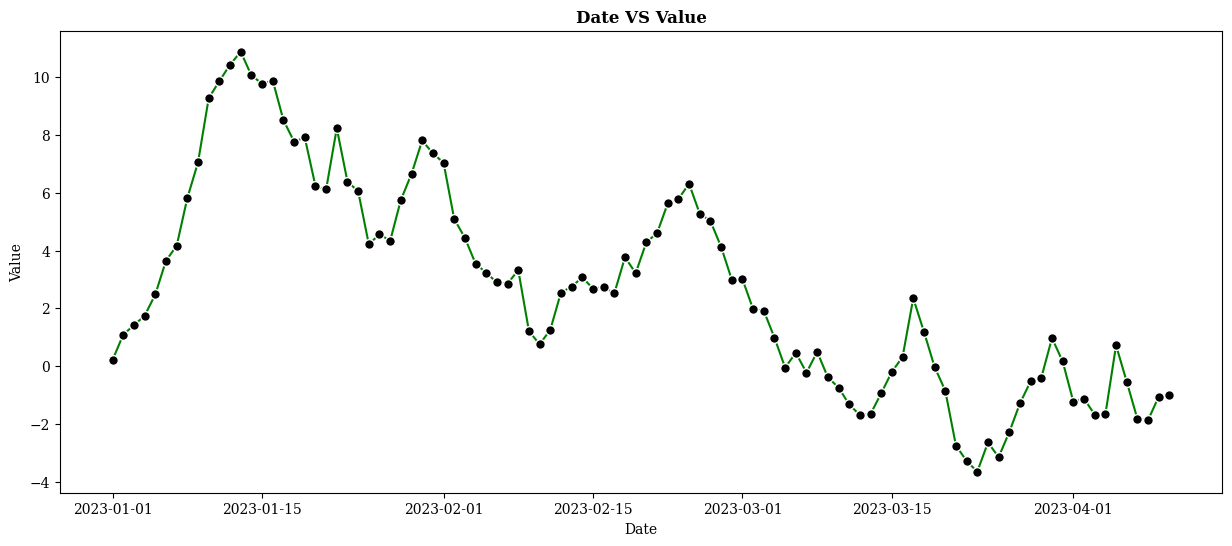

In [51]:
import matplotlib.pyplot as plt
increase_graph_size(15, 6)
set_labels_settings()
set_title_settings()
# set_grid()
# reset_settings()
set_line_settings(marker="o", markerfacecolor="black", markeredgecolor="white", markersize=7)
lineplot(df_line, "Date", "Value")

In [13]:
print(type(df))
df.read_parquet_metadata()

<class 'pandas.core.frame.DataFrame'>


AttributeError: 'DataFrame' object has no attribute 'read_parquet_metadata'

In [ ]:
print(type(df))
df.get_memory_usage()

In [ ]:
df.get_dataframe_mem_insight()

In [ ]:
df.get_dataframe_mem_insight(transpose=True)

In [ ]:
df.get_best_dtypes()

In [ ]:
print(type(df))
df = df.get_best_dtypes(show_df=True, convert=True)

In [ ]:
print(type(df))
df.get_memory_usage()

In [ ]:
df.get_dataframe_values_insight()

In [ ]:
df.get_dataframe_values_insight(transpose=True)

In [ ]:
print(type(df))
df = df.capitalize_rows_string(cols=["Gender"])
df.head()

In [ ]:
df = df.round_rows_value(cols=["Ticket_Price"], decimals=3)
df.head()

In [ ]:
Visualization.help_telegram_bot()

In [ ]:
Visualization.save_telegram_credentials()

In [1]:
Visualization.send_images_via_telegram(file_path="imgs/suntzulogo.png", caption="lefa")

NameError: name 'Visualization' is not defined

In [ ]:
Visualization.help_slack_bot()

In [ ]:
Visualization.save_slack_credentials()

In [ ]:
Visualization.send_images_via_slack(file_path="imgs/suntzulogo.png", caption="Logo")

In [ ]:
df = pd.read_csv("./Titanic.csv")
df1 = pd.read_csv("./Sales_Data.csv")
df2 = pd.read_parquet("./Titanic_Cleaned.parquet")

In [ ]:
# Define the string
my_string = "HellO, wOrld!"

# Define the character you want to check for
character_to_check = "o"

# Check if the character is in the string
if character_to_check.lower() in my_string.lower():
    print(f"The character '{character_to_check}' is in the string.")
else:
    print(f"The character '{character_to_check}' is not in the string.")


In [ ]:
import pandas as pd

# Creating a DataFrame for testing
data = {
    'name': ['Alice', 'Bob', 'Charlie', 'David', 'Emma'],
    'age': [25, 30, 35, 40, None],
    'Gender': ['female', 'male', None, 'male', 'female'],
    'City': ['New York', 'Los Angeles', 'Chicago', 'Houston', 'Phoenix'],
    'SCORE': [85.5, None, 90.7, 75.2, 88.9]
}
df = pd.DataFrame(data)
df.head()

In [ ]:
df.head()

In [ ]:
df1.head()

In [ ]:
erro

In [ ]:
# self.info()

In [ ]:
# teste = File.read_file("./Titanic_Cleaned.parquet")
# teste.info()

In [ ]:
import pandas as pd
# Criar um DataFrame de exemplo
data = {
    'Name': ['Alice', 'Bob', 'Charlie', 'David', 'Emma'],
    'Age': [25, 30, 35, 40, 45],
    'Gender': ['Female', 'Male', 'Male', 'Male', 'Female'],
    'City': ['New York', 'Los Angeles', 'Chicago', 'Houston', 'Phoenix']
}
df = pd.DataFrame(data)
df.head()

In [ ]:
# Conditions for filtering
conditions = [
    df['Age'] <= 35,
    df['Gender'] == 'Male'
]
df_find = Statistics.find(df, conditions)
df_find.head()

In [ ]:
df_replaced = Statistics.find_replace(df, conditions, ('Age', 'Unknown'))
df_replaced.head()

In [ ]:
# df_deleted = Statistics.find_delete(df, conditions)
# df_deleted.head()

In [ ]:
# Statistics.get_best_dtypes(self, output=True, convert=True)

In [ ]:
# Statistics.get_null_percentage(teste, get_dict=True, output=False, get_total=False)

In [ ]:
# Metadata.read_netCDF_metadata(teste)

In [ ]:
# teste.head()

In [ ]:
# get_nulls_count(teste1)

In [ ]:
# import pandas as pd

# # Creating a sample DataFrame
# data = {
#     'col1': ['apple, pie', 'banana! split', 'cherry? cake'],
#     'col2': ['ice-cream', 'chocolate? cake', 'strawberry! shortcake']
# }

# teste = pd.DataFrame(data)
# teste.head()


In [ ]:
# self.head()

In [ ]:
# self = pd.read_csv("./Titanic.csv")
# condition = self["sex"] == "female"
# conditions = [condition]
# teste = find_delete(self, conditions)
# teste["sex"].value_counts()

In [ ]:
# self = pd.read_csv("./Titanic.csv")
# condition = self["sex"] == "female"
# conditions = [condition]
# replace = ["survived", 1]
# teste = replace.values()
# teste
# teste = find_replace(self, conditions, replace)
# teste4 = find(teste, conditions)
# teste4["survived"].value_counts()

In [ ]:
# self = pd.read_csv("./Titanic.csv")
# teste2 = find(self, [self["sex"] == "female"])
# self.loc[teste2.index, "survived"] = 0
# teste3 = find(self, [self["sex"] == "female"])
# teste3["survived"].value_counts()

In [ ]:
# condition = self["sex"] == "female"
# conditions = [condition]
# replace = [self["survived"], 1]
# teste = replace.values()
# teste
# teste = find_replace(self, conditions, replace)
# teste.head()
# teste1 = find(teste, conditions)
# teste1["survived"].value_counts()
# adw = find(teste, conditions)
# teste.head()
# df["female"].value_counts()

In [ ]:
# teste.head()

In [ ]:
# teste = remove_rows_character(teste, characters=["-", "?", "!", " ", ","], add_blankspace=True)
# teste.head()

In [ ]:
# df1["Product"].dtypes

In [ ]:
# get_nulls_count(df1)

In [ ]:
# df1.info()

In [ ]:
# get_dtype(df1, "Product")

In [ ]:
# df1 = get_best_dtypes(df1, convert=True)

In [ ]:
# df1.info()

In [ ]:
# df1 = remove_rows_with_missing_values(df1)
#Gender	Age	Siblings_on_Board	Parents_on_Board	Ticket_Price	Port_of_Embarkation	Class	Adult/Child	Alone	Survived

In [ ]:
import pandas as pd
teste = pd.read_csv("examples/Titanic.csv")
teste.head()
teste.drop(columns=["Ticket", "Cabin", "PassengerId", "Name", "Pclass"], inplace=True)
teste.head()

In [ ]:
teste['Port_of_Embarkation'] = teste['Port_of_Embarkation'].map({'S': 'Southampton', 'C': 'Cherbourg', 'Q': 'Queenstown'})

In [ ]:
teste = teste.rename(columns={'Sex': 'Gender', 'Sibsp': 'Siblings_on_Board', 'Parch': 'Parents_on_Board', 'Fare': 'Ticket_Price', 'Embarked': 'Port_of_Embarkation', 'Survived':'Survived'})

In [ ]:
teste.head()

In [ ]:
# get_col_null_count(df1, ["Purchase Address"])

In [ ]:
Cleaning.split_rows_string(df1, "Purchase Address", ["Address", "City", "State"], delete_col=False)